In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
# from torch.utils.tensorboard import SummaryWriter
# from torchsummary import summary


In [3]:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                    ])

    transform_valid = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])


    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    valid_data = MNIST(root='./datasets', train=True, download=True, transform=transform_valid)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, sampler=train_sampler,pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sz, sampler=valid_sampler,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, test_loader



In [4]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
train_loader, valid_loader, test_loader=mnist(batch_sz)

21.8%

100.0%


Extracting ./datasets\MNIST\raw\train-images-idx3-ubyte.gz to ./datasets\MNIST\raw


100.0%
13.9%


Extracting ./datasets\MNIST\raw\train-labels-idx1-ubyte.gz to ./datasets\MNIST\raw



100.0%
100.0%


Extracting ./datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to ./datasets\MNIST\raw

Extracting ./datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./datasets\MNIST\raw



Defining a | conv neural network with 2 conv layers and 2 fully connected layers.

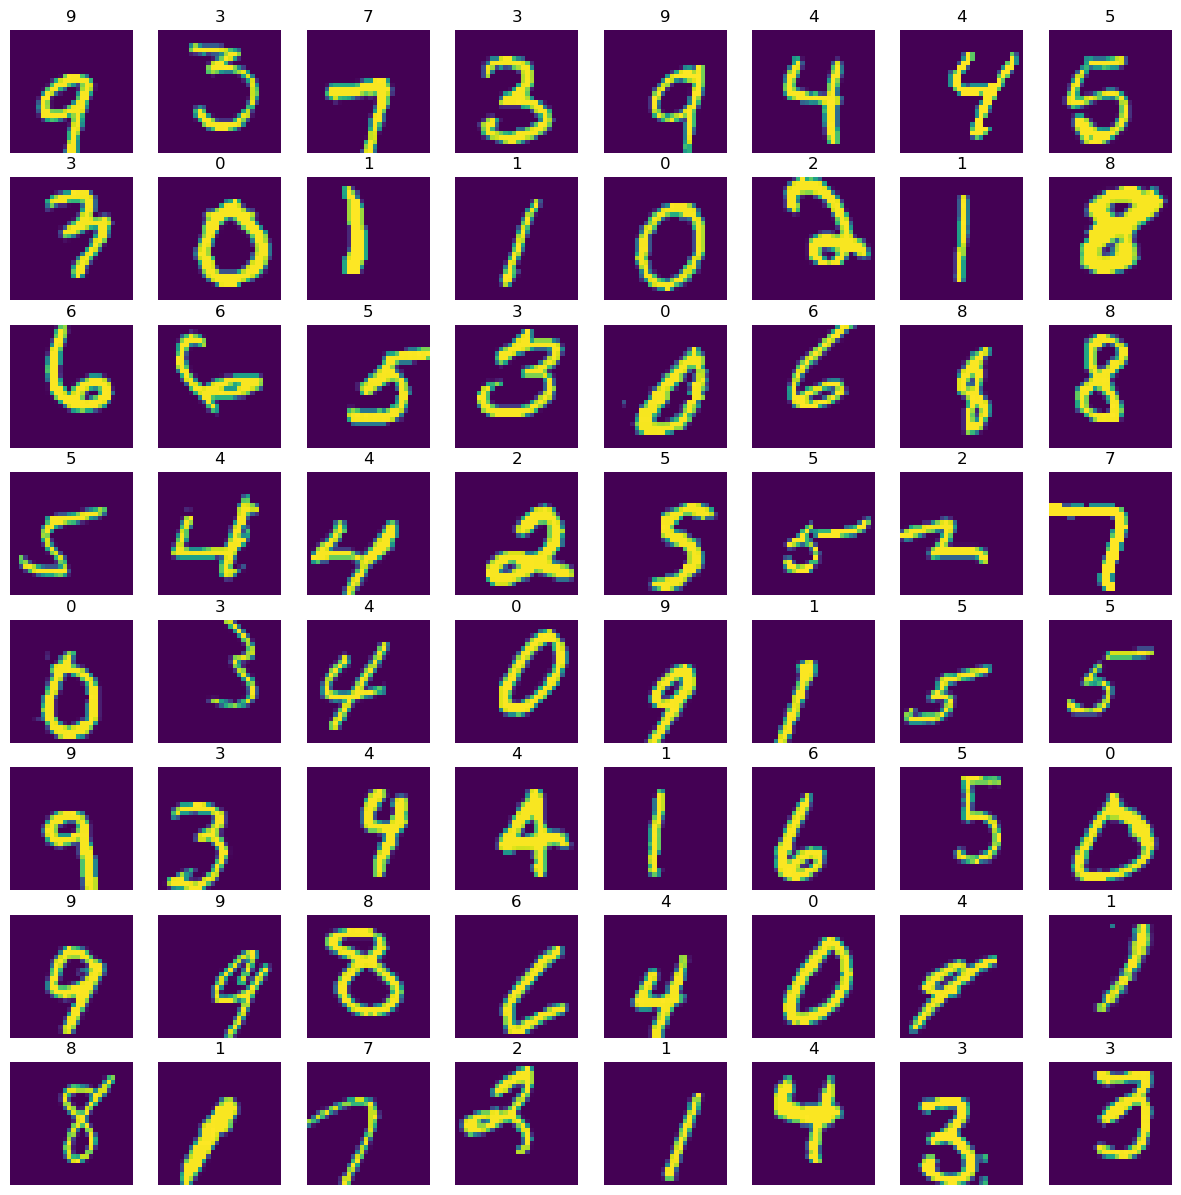

In [5]:
batch = next(iter(train_loader))
images = batch[0]
labels = batch[1]
plt.figure(figsize=(15,15))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(images[i,0,:,:])
  plt.title(labels[i].item())
  plt.axis("off")

In [6]:
class MyCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 50, 3, 1)
    self.conv2 = nn.Conv2d(50, 10, 3, 1)
    self.linear1 = nn.Linear(10*2*2, 100)
    self.linear2 = nn.Linear(100, 10)

  def forward(self, x):
    #feature exractor
    #Torch convention --->(batch_size, channels, rows, cols)
    # x---->(bs,1, 28,28)
    x = self.conv1(x)
    x = torch.relu(x)
    # x ---->(bs, 10, 26, 26)
    x1 = F.max_pool2d(x, (2,2))
    # x ---->(bs, 10, 13, 13)
    x = self.conv2(x1)
    x =torch.relu(x)
    # x ---->(bs, 50, 11, 11)
    x2 = F.max_pool2d(x, (4,4))
    # x ---->(bs, 50, 5, 5)

    #classifier
    x3 = x2.view(-1, 10*2*2)


    # x ---->(bs, 50*5*5)
    x = self.linear1(x3)
    x = torch.relu(x)
    x = self.linear2(x)
    #x --->(bs, 10)
    return (x, x1, x2, x3)



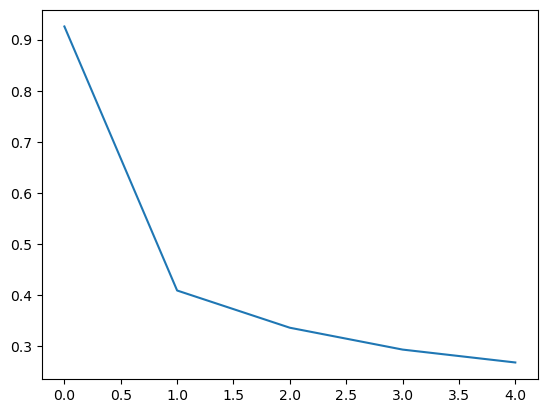

In [10]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

net = MyCNN().to(device)

lr = .1
momentum = 0.5
opt = optim.SGD(net.parameters(), lr = lr, momentum = momentum)


num_epochs = 5
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X, Y = batch[0].to(device), batch[1].to(device)
    logits = net(X)[0]

    loss = F.cross_entropy(logits, Y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss/len(train_loader))


plt.plot(ls)


tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3], device='cuda:0')


<Figure size 640x480 with 0 Axes>

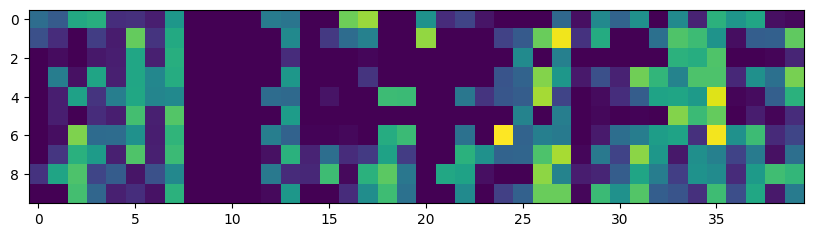

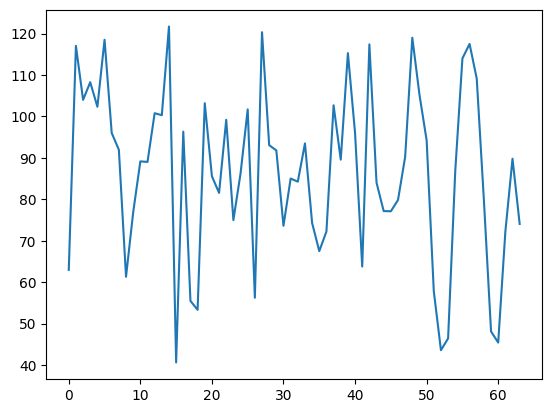

In [ ]:
with torch.no_grad():
  batch = next(iter(test_loader))
  X = batch[0].to(device)
  Y = batch[1].to(device)
  logits, Y1, Y2, Y3 = net(X)
  Y1 = Y1.detach().cpu().numpy()
  Y2 = Y2.detach().cpu().numpy()
  Y3 = Y3.detach().cpu().numpy()
  plt.figure()
  sample_number = 0
  # for i in range(Y1.shape[1]):
  #   plt.subplot(2,5, i+1)
  #   plt.imshow(Y1[sample_number, i, :,:])

  # plt.figure()
  # for i in range(Y2.shape[1]):
  #   plt.subplot(5,10, i+1)
  #   plt.imshow(Y2[sample_number, i, :,:])

  plt.figure(figsize=(10,10))
  plt.imshow(Y3[:10,:])
  print(Y)
  plt.figure()
  plt.plot(Y3[:,:]  @ Y3[2,:].T)







In [ ]:
w1 = net.conv1.weight.detach().cpu().numpy()
# w1 --->(1, 10, 3,3)
for i in range(w1.shape[0]):
  plt.figure()
  for j in range(w1.shape[1]):
    plt.subplot(1, w1.shape[1], j+1)
    plt.imshow(w1[i, j,:,:])

In [ ]:
w2 = net.conv2.weight.detach().cpu().numpy()
# w1 --->(10, 1,3,3)
for i in range(15):#range(w2.shape[0]):
  plt.figure(figsize=(10,10))
  for j in range(w2.shape[1]):
    plt.subplot(1, w2.shape[1], j+1)
    plt.imshow(w2[ i, j, :,:])
    plt.axis("off")

In [ ]:
with torch.no_grad():
  correct = 0
  total = 0
  for batch in test_loader:
    X = batch[0].to(device)
    Y = batch[1].to(device)
    logits, Y1, Y2, Y3 = net(X)
    logits = logits.detach().cpu().numpy()
    Y = Y.detach().cpu().numpy()
    pred = np.argmax(logits, axis = 1)
    correct += np.sum(pred == Y)
    total+=X.shape[0]


print(correct/total)


0.9461


In [ ]:
pred.shape

(16,)

In [ ]:
Y.shape

(16,)

In [ ]:
np.argmax(logits, axis = 1).shape

(16,)

In [ ]:
#average pooling: [[1, 0],[5, 2]] ---> [[2]]
#max pooling: [[1, 0],[5, 2]] ---> [[5]]